In [1]:
import pandas as pd
tweets = pd.read_csv("Tweetss.csv")

tweets.isnull().values.any()

tweets.shape

(14640, 2)

In [2]:
tweets.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


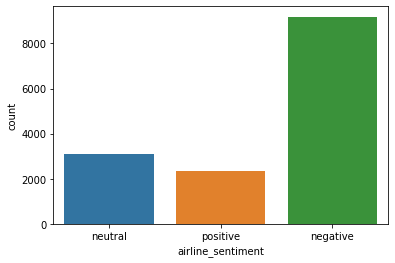

In [3]:
import seaborn as sns

sns.countplot(x='airline_sentiment', data=tweets)

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import GlobalMaxPooling1D
from keras.layers import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import LeakyReLU
from keras.layers import Activation,Conv1D,MaxPooling1D,Flatten
from keras.layers import Embedding,LSTM
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dark1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import re

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.add('http')
stemmer=nltk.stem.WordNetLemmatizer()
def text_prepare(text):

   
    remove_tags(text)  
    # text = re.sub('[^a-zA-Z]', ' ', text)# Remove punctuations and numbers
    # text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)# Single character removal
    # text = re.sub(r'\s+', ' ', text)# Removing multiple spaces
    text = text.lower()# lowercase text  
    text = re.sub(REPLACE_BY_SPACE_RE,' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text    
    text = re.sub(BAD_SYMBOLS_RE,' ',text)# delete symbols which are in BAD_SYMBOLS_RE from text
    
    text = ' '.join(s for s in text.split() if s not in STOPWORDS)# delete stopwords from text  
    text = ' '.join(stemmer.lemmatize(token) for token in text.split())
    return text

In [8]:
X = []
sentences = list(tweets['text'])
for sen in sentences:
    X.append(text_prepare(sen))

In [9]:
X[3]

'virginamerica really aggressive blast obnoxious entertainment guest face amp little recourse'

In [10]:
import numpy as np

Y=tweets['airline_sentiment']
Y = np.array(Y)
Y=list(Y)

In [11]:
for x,i in enumerate(Y) :
    if i=='positive' :
        Y[x]=1
    elif i=='neutral':
        Y[x]=2
    else :
        Y[x]=0     

In [12]:
Y=np.array(Y)
Y[4]

0

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [14]:
np.count_nonzero(Y_train == 2)

2519

In [15]:
np.count_nonzero(Y_test == 2)

580

In [16]:
np.count_nonzero(Y_train == 0)

7289

In [17]:
np.count_nonzero(Y_test == 0)

1889

In [18]:
np.count_nonzero(Y_train == 1)

1904

In [19]:
np.count_nonzero(Y_test == 1)

459

In [20]:
from collections import defaultdict

words_counts = defaultdict(int)
for text in X_train:
    for word in text.split():
        words_counts[word] += 1

In [21]:
#print(words_counts)

In [22]:
print(len(words_counts))

12880


In [23]:
DICT_SIZE = 9016
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = {p[0]:i for i,p in enumerate(most_common_words[:DICT_SIZE])}
def my_bag_of_words(text, words_to_index, dict_size):

    result_vector = np.zeros(dict_size)
    for word in text.split():
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1
    return result_vector


In [24]:
#print(most_common_words)

In [25]:
#print(WORDS_TO_INDEX)

In [27]:
from scipy import sparse as sp_sparse
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])


X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])


In [28]:
print('X_train shape ', X_train_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (11712, 9016)
X_test shape  (2928, 9016)


In [29]:
print( X_train_mybag[1].shape)

(1, 9016)


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
def tfidf_features(X_train, X_test):

    
    tfidf_vectorizer = TfidfVectorizer(min_df=3,max_df=0.80, ngram_range=(1,2))
    X_train = tfidf_vectorizer.fit_transform(X_train)   
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train,X_test, tfidf_vectorizer.vocabulary_

In [32]:
X_train_tfidf,X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [26]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_tk = tokenizer.texts_to_sequences(X_train)
X_test_tk = tokenizer.texts_to_sequences(X_test)

In [27]:
print(X_train[3]) 

americanair flight 3056 still sitting dfw waiting baggage loaded


In [28]:
print(X_test[3]) 

jetblue depart washington c


In [29]:
X_test_tk[3]

[6, 804, 1281, 257]

In [30]:
maxlen=20
X_train_tk = pad_sequences(X_train_tk, padding='post', maxlen=maxlen)
X_test_tk = pad_sequences(X_test_tk, padding='post', maxlen=maxlen)

In [31]:
X_train_tk[3]

array([   4,    1, 1939,   26,  120,  144,   53,  105, 1080,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [32]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.twitter.27B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [33]:
vocab_size = len(tokenizer.word_index)+1

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [34]:
from keras.utils import to_categorical
Y_train_oh = to_categorical(Y_train)
Y_test_oh= to_categorical(Y_test)
print(Y_train)

[0 0 1 ... 0 0 2]


In [35]:
print( len(embedding_matrix))
print(len(embedding_matrix[0]))

12398
100


In [36]:
class_weight = {0: 1.,
                1: 4.,
                2: 3.}

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
model = LogisticRegression()
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)



C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [44]:
from sklearn import metrics

In [45]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[1712,   47,  130],
       [  94,  321,   44],
       [ 208,   55,  317]], dtype=int64)

In [46]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred_mybag)

0.8025956284153005

In [47]:
model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)



In [48]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[1797,   31,   61],
       [ 139,  278,   42],
       [ 310,   37,  233]], dtype=int64)

In [49]:
accuracy_score(Y_test, Y_pred_tfidf)

0.7882513661202186

In [54]:
model.fit(X_train_tk,Y_train)

Y_pred_tfidf=model.predict(X_test_tk)

C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [55]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[1888,    0,    1],
       [ 458,    0,    1],
       [ 577,    0,    3]], dtype=int64)

In [56]:
accuracy_score(Y_test, Y_pred_tfidf)

0.6458333333333334

In [57]:
from sklearn.svm import SVC

In [58]:
model = SVC(C=600)
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)


C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [59]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[1704,   47,  138],
       [ 100,  295,   64],
       [ 210,   51,  319]], dtype=int64)

In [60]:
accuracy_score(Y_test, Y_pred_mybag)

0.7916666666666666

In [61]:

model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)


C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [62]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[1850,   24,   15],
       [ 213,  225,   21],
       [ 454,   24,  102]], dtype=int64)

In [63]:
accuracy_score(Y_test, Y_pred_tfidf)

0.7435109289617486

In [64]:
model.fit(X_train_tk,Y_train)

Y_pred_tfidf=model.predict(X_test_tk)

C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [65]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[1872,    2,   15],
       [ 406,   45,    8],
       [ 525,    7,   48]], dtype=int64)

In [66]:
accuracy_score(Y_test, Y_pred_tfidf)

0.6711065573770492

In [67]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
model = RandomForestClassifier(600)
model.fit(X_train_mybag,Y_train)
Y_pred_rf=model.predict(X_test_mybag)

model.score(X_test_mybag,Y_test)

0.773224043715847

In [69]:
from sklearn import metrics

In [70]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_rf)
cnf_matrix

array([[1729,   44,  116],
       [ 120,  277,   62],
       [ 269,   53,  258]], dtype=int64)

In [71]:
accuracy_score(Y_test, Y_pred_rf)

0.773224043715847

In [72]:
model = RandomForestClassifier(600)
model.fit(X_train_tfidf,Y_train)
Y_pred_tfidf=model.predict(X_test_tfidf)

model.score(X_test_tfidf,Y_test)

0.7667349726775956

In [73]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[1760,   42,   87],
       [ 135,  261,   63],
       [ 311,   45,  224]], dtype=int64)

In [74]:
accuracy_score(Y_test, Y_pred_tfidf)

0.7667349726775956

In [75]:
model.fit(X_train_tk,Y_train)

Y_pred_tfidf=model.predict(X_test_tk)

In [76]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[1750,   34,  105],
       [ 286,  109,   64],
       [ 341,   56,  183]], dtype=int64)

In [77]:
accuracy_score(Y_test, Y_pred_tfidf)

0.6974043715846995

In [78]:
from sklearn import tree

In [79]:
model= tree.DecisionTreeClassifier()

In [80]:
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)


In [81]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[1498,  128,  263],
       [ 109,  278,   72],
       [ 245,   82,  253]], dtype=int64)

In [82]:
accuracy_score(Y_test, Y_pred_mybag)

0.692964480874317

In [83]:
model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)



In [84]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[1493,  139,  257],
       [ 109,  269,   81],
       [ 251,   86,  243]], dtype=int64)

In [85]:
accuracy_score(Y_test, Y_pred_tfidf)

0.6847677595628415

In [86]:
model.fit(X_train_tk,Y_train)

Y_pred_tfidf=model.predict(X_test_tk)

In [87]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[1349,  241,  299],
       [ 198,  168,   93],
       [ 247,  109,  224]], dtype=int64)

In [88]:
accuracy_score(Y_test, Y_pred_tfidf)

0.594603825136612

In [61]:
from keras import metrics

In [65]:
from sklearn import metrics
from sklearn.metrics import recall_score  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
import matplotlib. pyplot as plt

In [57]:
#deep learning

In [38]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(128, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.6))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dropout(0.6))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(8, activation='tanh'))

model.add(Dropout(0.6))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           1239800   
_________________________________________________________________
flatten_1 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               256128    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)               

In [39]:
history = model.fit(X_train_tk, Y_train_oh, batch_size=32, epochs=10, verbose=1, validation_split=0.2,class_weight=class_weight )

Train on 9369 samples, validate on 2343 samples
Epoch 1/10
9369/9369 [==============================] - 5s 489us/step - loss: 2.0923 - acc: 0.3661 - recall_1: 0.5982 - precision_1: 0.3675 - val_loss: 2.0102 - val_acc: 0.2429 - val_recall_1: 0.7776 - val_precision_1: 0.4013
Epoch 2/10
9369/9369 [==============================] - 2s 192us/step - loss: 1.9973 - acc: 0.4355 - recall_1: 0.6348 - precision_1: 0.4068 - val_loss: 1.8310 - val_acc: 0.6872 - val_recall_1: 0.8464 - val_precision_1: 0.5344
Epoch 3/10
9369/9369 [==============================] - 2s 207us/step - loss: 1.9016 - acc: 0.5422 - recall_1: 0.6822 - precision_1: 0.4658 - val_loss: 1.7400 - val_acc: 0.6317 - val_recall_1: 0.8020 - val_precision_1: 0.5110
Epoch 4/10
9369/9369 [==============================] - 2s 207us/step - loss: 1.8192 - acc: 0.5892 - recall_1: 0.7017 - precision_1: 0.5062 - val_loss: 1.6635 - val_acc: 0.6556 - val_recall_1: 0.7921 - val_precision_1: 0.5634
Epoch 5/10
9369/9369 [==========================

In [42]:
pr = model.predict(X_test_tk)

In [43]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))
print(cnf_matrix)

[[1329  143  417]
 [  37  332   90]
 [ 128  105  347]]


In [44]:
recall_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.6857923497267759

In [45]:
mean_squared_error(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.8726092896174863

In [46]:
precision_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.6857923497267759

In [47]:
accuracy_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.6857923497267759

In [48]:
 import matplotlib. pyplot as plt

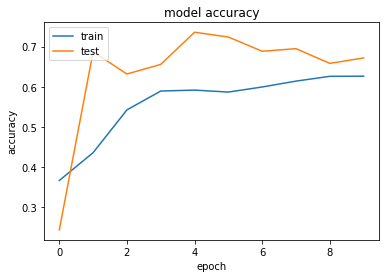

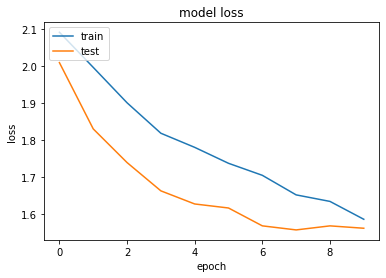

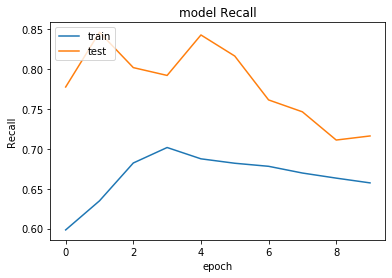

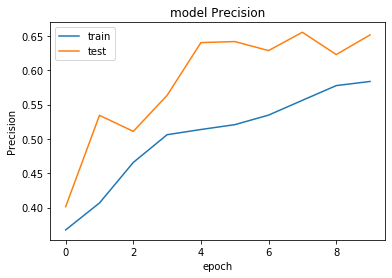

In [49]:
    
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_1'])
plt.plot(history.history['val_precision_1'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [37]:
#cnn

In [51]:

model= Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 2, activation='tanh'))
model.add(Conv1D(64, 2, activation='tanh'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D())
model.add(Dropout(0.6))
model.add(Conv1D(32, 2,activation='tanh'))
model.add(Conv1D(16, 2, activation='tanh'))
model.add(MaxPooling1D())

model.add(Dropout(0.6))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv1D(8, 2, activation='tanh'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.6))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 100)           1239800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19, 128)           25728     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 64)            16448     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 18, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 64)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 9, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 32)            

In [52]:
history = model.fit(X_train_tk, Y_train_oh, batch_size=128, epochs=10, verbose=1, validation_split=0.2,class_weight=class_weight)

Train on 9369 samples, validate on 2343 samples
Epoch 1/10
9369/9369 [==============================] - 3s 275us/step - loss: 2.1397 - acc: 0.2668 - recall_2: 0.5750 - precision_2: 0.3258 - val_loss: 2.0658 - val_acc: 0.3030 - val_recall_2: 0.8156 - val_precision_2: 0.3875
Epoch 2/10
9369/9369 [==============================] - 2s 180us/step - loss: 2.0550 - acc: 0.3265 - recall_2: 0.6298 - precision_2: 0.3550 - val_loss: 1.9829 - val_acc: 0.5903 - val_recall_2: 0.7921 - val_precision_2: 0.4091
Epoch 3/10
9369/9369 [==============================] - 2s 180us/step - loss: 1.9932 - acc: 0.4311 - recall_2: 0.6401 - precision_2: 0.3850 - val_loss: 1.8963 - val_acc: 0.6261 - val_recall_2: 0.7529 - val_precision_2: 0.4327
Epoch 4/10
9369/9369 [==============================] - 2s 193us/step - loss: 1.9386 - acc: 0.5439 - recall_2: 0.6835 - precision_2: 0.4278 - val_loss: 1.8333 - val_acc: 0.6342 - val_recall_2: 0.7529 - val_precision_2: 0.4430
Epoch 5/10
9369/9369 [==========================

In [53]:
pr = model.predict(X_test_tk)

In [55]:
cnf_matrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))
print(cnf_matrix)

[[1757  132    0]
 [ 111  348    0]
 [ 443  137    0]]


In [56]:
recall_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.7189207650273224

In [57]:
mean_squared_error(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.7349726775956285

In [58]:
precision_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.7189207650273224

In [59]:
accuracy_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.7189207650273224

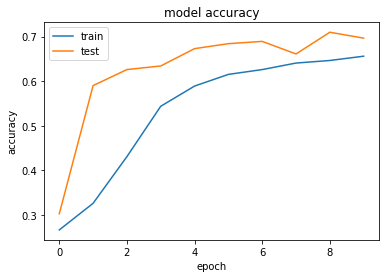

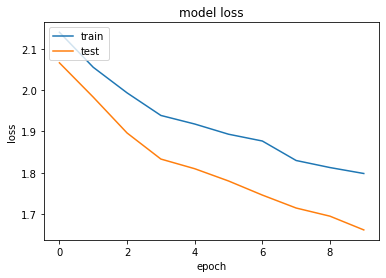

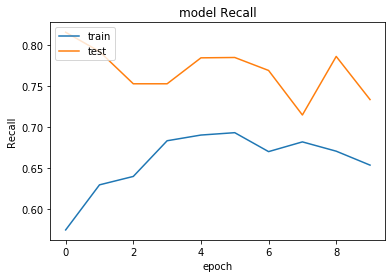

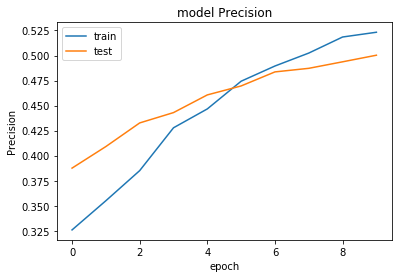

In [60]:
    
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_2'])
plt.plot(history.history['val_recall_2'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_2'])
plt.plot(history.history['val_precision_2'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [48]:
#lstm

In [62]:

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128,return_sequences = True))
model.add(LSTM(64,return_sequences = True))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.6))
model.add(LSTM(32,return_sequences = True))
model.add(LSTM(16,return_sequences = True))
model.add(Dropout(0.6))
model.add(LeakyReLU(alpha=0.1))
model.add(LSTM(8,return_sequences = False))

model.add(Dropout(0.6))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())




Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 100)           1239800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 128)           117248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 64)            49408     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 20, 64)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 32)            12416     
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 16)           

In [63]:
history = model.fit(X_train_tk, Y_train_oh, batch_size=128, epochs=10, verbose=1, validation_split=0.2,class_weight=class_weight)



Train on 9369 samples, validate on 2343 samples
Epoch 1/10
9369/9369 [==============================] - 13s 1ms/step - loss: 2.0269 - acc: 0.4168 - recall_3: 0.6631 - precision_3: 0.4267 - val_loss: 1.9971 - val_acc: 0.2471 - val_recall_3: 0.8314 - val_precision_3: 0.4260
Epoch 2/10
9369/9369 [==============================] - 13s 1ms/step - loss: 1.9217 - acc: 0.4587 - recall_3: 0.7487 - precision_3: 0.4455 - val_loss: 1.8347 - val_acc: 0.6795 - val_recall_3: 0.8912 - val_precision_3: 0.4610
Epoch 3/10
9369/9369 [==============================] - 15s 2ms/step - loss: 1.8357 - acc: 0.4965 - recall_3: 0.7616 - precision_3: 0.4612 - val_loss: 1.7769 - val_acc: 0.6475 - val_recall_3: 0.8259 - val_precision_3: 0.4491
Epoch 4/10
9369/9369 [==============================] - 16s 2ms/step - loss: 1.8160 - acc: 0.5139 - recall_3: 0.7443 - precision_3: 0.4697 - val_loss: 1.7524 - val_acc: 0.6547 - val_recall_3: 0.7934 - val_precision_3: 0.4840
Epoch 5/10
9369/9369 [==============================

In [88]:
pr = model.predict(X_test_tk)

In [66]:
cnf_matrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))
print(cnf_matrix)

[[1757  132    0]
 [ 111  348    0]
 [ 443  137    0]]


In [67]:
recall_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.7189207650273224

In [68]:
mean_squared_error(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.7349726775956285

In [69]:
precision_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.7189207650273224

In [70]:
accuracy_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.7189207650273224

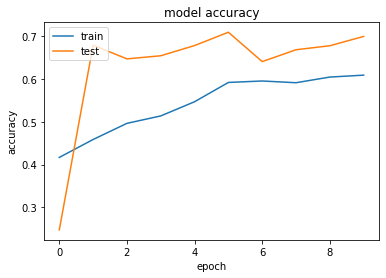

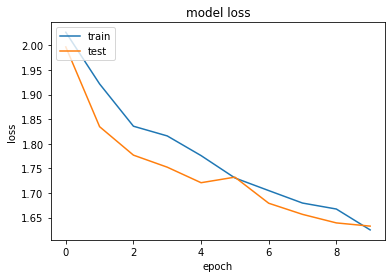

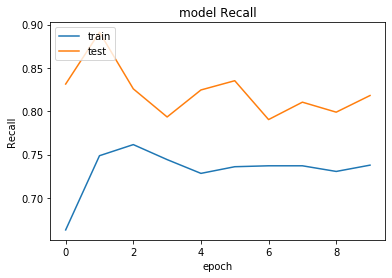

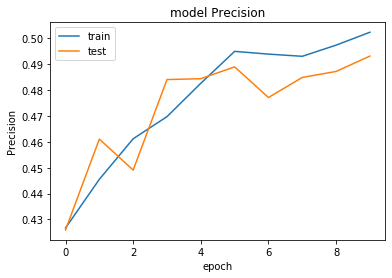

In [72]:
    
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_3'])
plt.plot(history.history['val_recall_3'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_3'])
plt.plot(history.history['val_precision_3'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [34]:
#tfidf


In [97]:
model = Sequential()

model.add(Dense(128,input_shape= (8190,), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.6))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dropout(0.6))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(8, activation='tanh'))

model.add(Dropout(0.6))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               1048448   
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_17 (Dropout)         (None, 16)               

In [98]:
history = model.fit(X_train_tfidf, Y_train_oh, batch_size=80, epochs=6, verbose=1, validation_split=0.2,class_weight=class_weight)

Train on 9369 samples, validate on 2343 samples
Epoch 1/6
9369/9369 [==============================] - 5s 579us/step - loss: 2.0828 - acc: 0.3887 - recall_6: 0.4939 - precision_6: 0.3685 - val_loss: 1.9480 - val_acc: 0.6765 - val_recall_6: 0.7012 - val_precision_6: 0.6764
Epoch 2/6
9369/9369 [==============================] - 5s 534us/step - loss: 1.8709 - acc: 0.5707 - recall_6: 0.6276 - precision_6: 0.5002 - val_loss: 1.6739 - val_acc: 0.6965 - val_recall_6: 0.8165 - val_precision_6: 0.6282
Epoch 3/6
9369/9369 [==============================] - 5s 548us/step - loss: 1.6543 - acc: 0.6863 - recall_6: 0.7209 - precision_6: 0.5932 - val_loss: 1.5987 - val_acc: 0.7435 - val_recall_6: 0.7939 - val_precision_6: 0.7168
Epoch 4/6
9369/9369 [==============================] - 5s 545us/step - loss: 1.5281 - acc: 0.7306 - recall_6: 0.7353 - precision_6: 0.6562 - val_loss: 1.5305 - val_acc: 0.7239 - val_recall_6: 0.7409 - val_precision_6: 0.7080
Epoch 5/6
9369/9369 [==============================]

In [100]:
pr = model.predict(X_test_tfidf)

In [101]:
cnf_matrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))
print(cnf_matrix)

[[1507   85  297]
 [  72  325   62]
 [ 155   94  331]]


In [102]:
recall_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.7387295081967213

In [103]:
mean_squared_error(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.7243852459016393

In [104]:
precision_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.7387295081967213

In [105]:
accuracy_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.7387295081967213

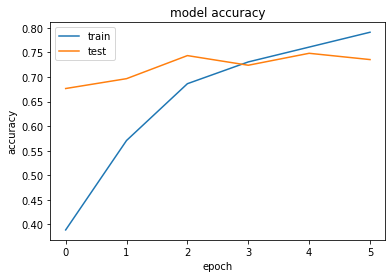

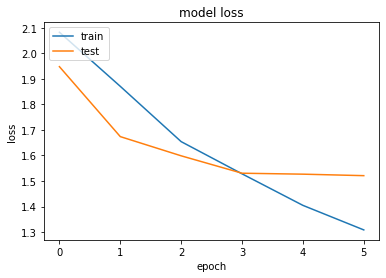

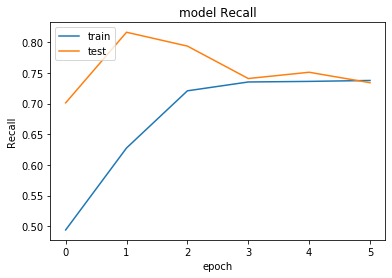

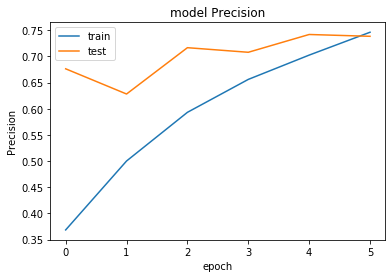

In [107]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_6'])
plt.plot(history.history['val_recall_6'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_6'])
plt.plot(history.history['val_precision_6'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [34]:
#bag of words


In [111]:
model = Sequential()

model.add(Dense(128,input_shape= (9016,), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.6))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dropout(0.6))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(8, activation='tanh'))

model.add(Dropout(0.6))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 128)               1154176   
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_20 (Dropout)         (None, 16)               

In [113]:
history = model.fit(X_train_mybag, Y_train_oh, batch_size=80, epochs=6, verbose=1, validation_split=0.2,class_weight=class_weight)

Train on 9369 samples, validate on 2343 samples
Epoch 1/6
9369/9369 [==============================] - 6s 687us/step - loss: 2.0698 - acc: 0.3881 - recall_7: 0.6708 - precision_7: 0.3426 - val_loss: 1.9217 - val_acc: 0.5809 - val_recall_7: 0.7350 - val_precision_7: 0.3912
Epoch 2/6
9369/9369 [==============================] - 6s 620us/step - loss: 1.9222 - acc: 0.5433 - recall_7: 0.7114 - precision_7: 0.4027 - val_loss: 1.7616 - val_acc: 0.6167 - val_recall_7: 0.6948 - val_precision_7: 0.4540
Epoch 3/6
9369/9369 [==============================] - 5s 577us/step - loss: 1.7759 - acc: 0.6533 - recall_7: 0.7366 - precision_7: 0.4698 - val_loss: 1.6266 - val_acc: 0.7085 - val_recall_7: 0.7337 - val_precision_7: 0.5092
Epoch 4/6
9369/9369 [==============================] - 5s 573us/step - loss: 1.6182 - acc: 0.7016 - recall_7: 0.7109 - precision_7: 0.5792 - val_loss: 1.5589 - val_acc: 0.7345 - val_recall_7: 0.7414 - val_precision_7: 0.7354
Epoch 5/6
9369/9369 [==============================]

In [115]:
pr = model.predict(X_test_mybag)

In [116]:
cnf_matrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))
print(cnf_matrix)

[[1508  102  279]
 [  59  338   62]
 [ 158   82  340]]


In [117]:
recall_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.7465846994535519

In [118]:
mean_squared_error(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.7011612021857924

In [119]:
precision_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.7465846994535519

In [120]:
accuracy_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.7465846994535519

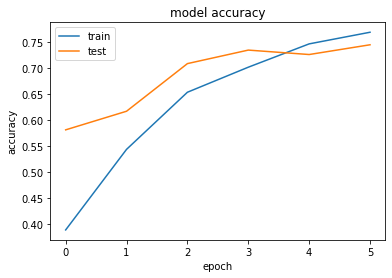

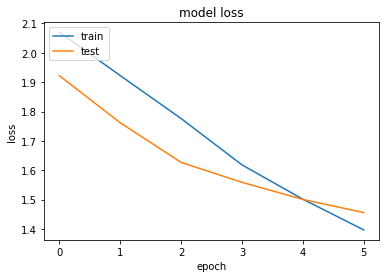

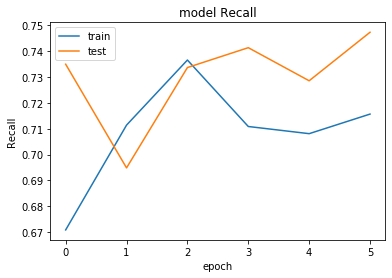

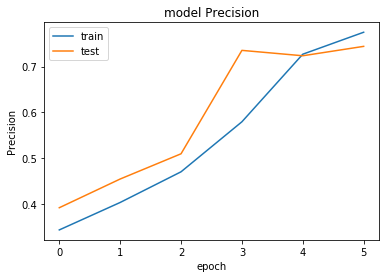

In [122]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_7'])
plt.plot(history.history['val_recall_7'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_7'])
plt.plot(history.history['val_precision_7'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [32]:
len(tfidf_reversed_vocab)

8190

In [33]:
X_train_tfidf_3d=X_train_tfidf.toarray()

In [34]:
print(X_train_tfidf_3d.shape)

(11712, 8190)


In [35]:
from numpy import  newaxis
X_train_tfidf_3d=X_train_tfidf_3d[:,:,newaxis]

In [36]:
print(X_train_tfidf_3d.shape)

(11712, 8190, 1)


In [37]:
X_test_tfidf_3d=X_test_tfidf.toarray()

In [38]:
print(X_test_tfidf_3d.shape)

(2928, 8190)


In [39]:
from numpy import  newaxis
X_test_tfidf_3d=X_test_tfidf_3d[:,:,newaxis]

In [40]:
print(X_test_tfidf_3d.shape)

(2928, 8190, 1)


In [41]:
X_train_mybag_3d=X_train_mybag.toarray()

In [42]:
print(X_train_mybag_3d.shape)

(11712, 9016)


In [43]:

X_train_mybag_3d=X_train_mybag_3d[:,:,newaxis]

In [44]:
print(X_train_mybag_3d.shape)

(11712, 9016, 1)


In [45]:
X_test_mybag_3d=X_test_mybag.toarray()

In [46]:
print(X_test_mybag_3d.shape)

(2928, 9016)


In [47]:

X_test_mybag_3d=X_test_mybag_3d[:,:,newaxis]

In [48]:
print(X_test_mybag_3d.shape)

(2928, 9016, 1)
